In [1]:
import string
from string import punctuation
from os import listdir
from collections import Counter
import re
import unicodedata

import pandas as pd
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import nltk    
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import wordnet
from nltk.corpus import stopwords 
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import wordnet
import random
import pickle

[nltk_data] Downloading package stopwords to /work/home/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /work/home/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /work/home/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


# Étape 1 : Télécharger et importer les données

Les données qui nous intéressent sont des commentaires de films. 

Nous avons utilisé les données <a href="http://ai.stanford.edu/~amaas/data/sentiment/">IMDb Reviews</a>. On peut les télécharger facilement en cliquant sur ce lien, puis sur "Large Movie Review Dataset v1.0". Le fichier aclImdb_v1.tar.gz sera alors téléchargé. Il suffira de l'extraire puis d'utiliser les fichiers .txt dans les dossiers neg et pos.

Nous importons maintenant les commentaires positifs et négatifs, en les mettant dans des listes negative_dataset et positive_dataset.

In [2]:
def load_doc(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

negative_dataset_train = []
for filename in listdir('aclImdb/train/neg'):
    if not filename.endswith(".txt"):
        continue
    path = 'aclImdb/train/neg' + '/' + filename
    read_file = load_doc(path)
    negative_dataset_train.append(read_file)  
    
positive_dataset_train = []
for filename in listdir('aclImdb/train/pos'):
    if not filename.endswith(".txt"):
        continue
    path = 'aclImdb/train/pos' + '/' + filename
    read_file = load_doc(path)
    positive_dataset_train.append(read_file)
    
negative_dataset_test = []
for filename in listdir('aclImdb/test/neg'):
    if not filename.endswith(".txt"):
        continue
    path = 'aclImdb/test/neg' + '/' + filename
    read_file = load_doc(path)
    negative_dataset_test.append(read_file)  
    
positive_dataset_test = []
for filename in listdir('aclImdb/test/pos'):
    if not filename.endswith(".txt"):
        continue
    path = 'aclImdb/test/pos' + '/' + filename
    read_file = load_doc(path)
    positive_dataset_test.append(read_file)

In [3]:
test_data = positive_dataset_test + negative_dataset_test
train_data = positive_dataset_train + negative_dataset_train

In [4]:
pos = positive_dataset_test + positive_dataset_train
neg = negative_dataset_test + negative_dataset_train

In [5]:
print(f'Taille des données train: {len(train_data)}')
print(f'Taille des données test: {len(test_data)}')

Taille des données train: 25000
Taille des données test: 25000


Nous avons alors un jeu de données de 50000 commentaires.

In [6]:
test_data, valid_data = test_data[0:12500] , test_data[12500:25000]

In [7]:
print(f'Taille des données train: {len(train_data)}')
print(f'Taille des données test: {len(test_data)}')
print(f'Taille des données de validation: {len(valid_data)}')

Taille des données train: 25000
Taille des données test: 12500
Taille des données de validation: 12500


# Étape 2 : Pré-traitement des données

Les commentaires bruts contiennent beaucoup de caractères, de ponctuation notamment qui ne nous permettront pas de faire une étude correcte sur ces commentaires.
Il faut alors "nettoyer" nos données.

Voici un exemple de commentaire "brut".

In [8]:
pos[0]

"Previous reviewer Claudio Carvalho gave a much better recap of the film's plot details than I could. What I recall mostly is that it was just so beautiful, in every sense - emotionally, visually, editorially - just gorgeous.<br /><br />If you like movies that are wonderful to look at, and also have emotional content to which that beauty is relevant, I think you will be glad to have seen this extraordinary and unusual work of art.<br /><br />On a scale of 1 to 10, I'd give it about an 8.75. The only reason I shy away from 9 is that it is a mood piece. If you are in the mood for a really artistic, very romantic film, then it's a 10. I definitely think it's a must-see, but none of us can be in that mood all the time, so, overall, 8.75."

Pour ce faire, on peut choisir de :

 - Segmenter les commentaire en "tokens", ici un token représentera un mot
 - Supprimer la ponctuation
 - Supprimer tous les nombres et caractères spéciaux
 - Mettre tout en minuscule
 - Supprimer les mots à une lettre
 - Supprimer les mots tels que "the", this"... appelés "stopwords"
 - Lemmatiser, c'est-à-dire, prendre la racine des mots. Par exemple, les mots "stepping", "stepped", "steps" seront transformés en "step"

On utilise la librairie nltk pour la lemmatisation.

In [9]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

lemmatizer = WordNetLemmatizer() 

On écrit alors la fonction qui va nous permettre de "nettoyer" les commentaires.

In [10]:
from nltk.util import ngrams
def clean_doc(doc):
    # tokenisation
    tokens = nltk.word_tokenize(doc)
    # suppression de la ponctuation
    table = str.maketrans(string.punctuation, ' '*len(string.punctuation))
    tokens = [w.translate(table) for w in tokens]
    # remplacement des espaces multiples en un seul espace
    tokens = [re.sub(r'\s+', ' ', word, flags=re.I) for word in tokens]
    # suppression des caractères spéciaux
    tokens = [word for word in tokens if word.isalpha()]
    # minuscule
    tokens = [word.lower() for word in tokens]
    # suppression des tokens de longueur inférieure à 1
    tokens = [word for word in tokens if len(word) > 1]
    # suppression des stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    # lemmatisation
    tokens = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in tokens]
    # étant donné que les commentaires concernent des films on supprime les mots "basiques"
    basic_words = ['film', 'movie', 'one', 'character', 'scene', 'make', 'see', 'go','story','time','br','watch', 'show', 'get']
    tokens = [w for w in tokens if not w in basic_words]
    return tokens

On crée également un dictionnaire "vocab" contenant tous les mots de ce corpus.

In [11]:
vocab = Counter()
tidy_review_neg = []

for review in neg:
    token = clean_doc(review)
    vocab.update(token)
    review = ' '.join(word for word in token)
    tidy_review_neg.append(review)
    
tidy_review_pos = []

for review in pos:
    token = clean_doc(review)
    vocab.update(token)
    review = ' '.join(word for word in token)
    tidy_review_pos.append(review)

In [12]:
print("Le vocabulaire contient : %s mots" 
       % len(vocab))

Le vocabulaire contient : 80418 mots


On obtient alors ce commentaire "nettoyé".

In [13]:
tidy_review_pos[0]

'previous reviewer claudio carvalho give much well recap plot detail could recall mostly beautiful every sense emotionally visually editorially like wonderful look also emotional content beauty relevant think glad extraordinary unusual work scale give reason shy away mood piece mood really artistic romantic definitely think none u mood overall'

In [14]:
data_neg = {'Reviews':neg,'Tidy_Reviews':tidy_review_neg, 'label': [0]*len(neg)}
data_neg = pd.DataFrame(data_neg)
data_pos = {'Reviews':pos, 'Tidy_Reviews':tidy_review_pos, 'label': [1]*len(pos)}
data_pos = pd.DataFrame(data_pos)

In [15]:
dataset = pd.concat([data_neg, data_pos])

On a le dataset suivant où les commentaires négatifs sont labélisés 0, et les commentaires positifs sont labélisés 1.

In [16]:
dataset.head(10)

,Reviews,Tidy_Reviews,label
0,I love sci-fi and am willing to put up with a ...,love willing put lot usually underfunded misun...,0
1,"Worth the entertainment value of a rental, esp...",worth entertainment value rental especially li...,0
2,its a totally average film with a few semi-alr...,totally average action sequence plot seem litt...,0
3,STAR RATING: ***** Saturday Night **** Friday ...,star rating saturday night friday night friday...,0
4,"First off let me say, If you haven't enjoyed a...",first let say enjoy van damme since bloodsport...,0
5,I had high hopes for this one until they chang...,high hope change name shepherd border patrol l...,0
6,Isaac Florentine has made some of the best wes...,isaac florentine best western martial art acti...,0
7,"It actually pains me to say it, but this movie...",actually pain say horrible every level blame l...,0
8,"Technically I'am a Van Damme Fan, or I was. th...",technically van damme fan bad hat waste minute...,0
9,"Honestly awful film, bad editing, awful lighti...",honestly awful bad edit awful light dire dialo...,0


On peut ensuite choisir de représenter les mots les plus fréquents dans les commentaires positifs et négatifs.

Pour cela, on utilise la librairie wordcloud. Les mots les plus fréquents sont de grandes tailles sur l'image.

In [17]:
from wordcloud import WordCloud,ImageColorGenerator
from PIL import Image
import urllib
import requests

 - Les mots dans les commentaires positifs

In [18]:
all_words_positive = ' '.join(text for text in dataset['Tidy_Reviews'][dataset['label']==1])
Mask = np.array(Image.open('./img/movie1.jpg'))
image_colors = ImageColorGenerator(Mask)
wc = WordCloud(background_color='white', height=1500, width=4000,mask=Mask).generate(all_words_positive)

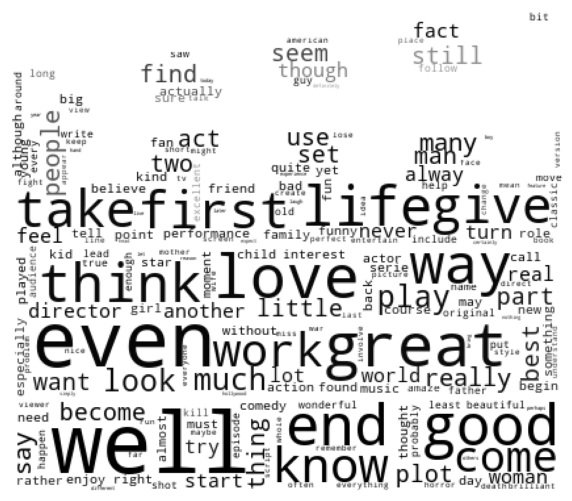

In [19]:
plt.figure(figsize=(10,20))
plt.imshow(wc.recolor(color_func=image_colors),interpolation="hamming")
plt.axis('off')
plt.show()

 - Les mots dans les commentaires négatifs

In [20]:
all_words_negative = ' '.join(text for text in dataset['Tidy_Reviews'][dataset['label']==0])
Mask = np.array(Image.open('./img/movie1.jpg'))
image_colors = ImageColorGenerator(Mask)
wc = WordCloud(background_color='white', height=1500, width=4000,mask=Mask).generate(all_words_negative)

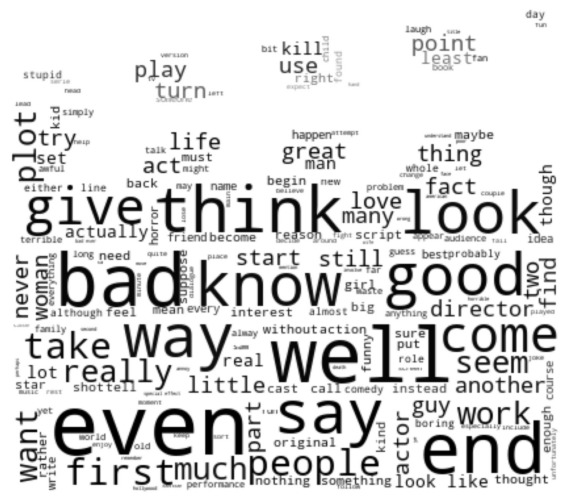

In [21]:
plt.figure(figsize=(10,20))
plt.imshow(wc.recolor(color_func=image_colors),interpolation="gaussian")
plt.axis('off')
plt.show()

On remarque que les mots qui ressortent des commentaires positifs sont plutôt positifs et que ceux des commentaires négatifs sont négatifs ou neutres. 
Par exemple, "show", "watch" sont des mots sans connotations particulières qui sont fréquents à la fois dans les commentaires positifs et négatifs.

 - Dans tous le dataset

In [22]:
freq_words = pd.DataFrame({'Word':list(vocab.keys()),'Count':list(vocab.values())})
freq_words.to_pickle("vocab.pkl") 

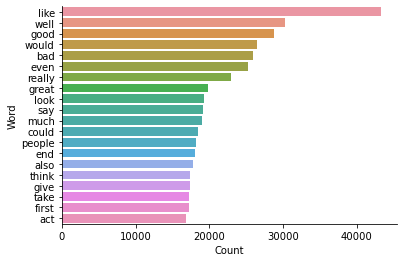

In [23]:
freq_words_plot = freq_words.nlargest(20,columns='Count')
sns.barplot(data=freq_words_plot,y='Word',x='Count')
sns.despine()

Le mot le plus fréquent est "like".

In [24]:
dataset.to_pickle("clean_data.pkl") 
dataset1 = dataset.drop(columns=['Reviews'])
dataset1.head()

,Tidy_Reviews,label
0,love willing put lot usually underfunded misun...,0
1,worth entertainment value rental especially li...,0
2,totally average action sequence plot seem litt...,0
3,star rating saturday night friday night friday...,0
4,first let say enjoy van damme since bloodsport...,0


In [25]:
# mélange les reviews
dataset1 = dataset.sample(frac=1)
dataset1 = dataset.rename(columns={"label": 'label', "Reviews": 'text'})

In [26]:
from sklearn.model_selection import train_test_split
train, data_test, label_train, label_test = train_test_split(dataset1["text"], dataset1["label"], test_size=0.2, random_state=42)
valid, test, label_valid, label_test = train_test_split(data_test, label_test, test_size=0.5, random_state=42)

train = pd.DataFrame({'text': train, 'label': label_train})
test = pd.DataFrame({'text': test, 'label': label_test})
valid = pd.DataFrame({'text': valid, 'label': label_valid})

train.to_csv (r'data/train.csv', index = False, header=True)
test.to_csv (r'data/test.csv', index = False, header=True)
valid.to_csv (r'data/valid.csv', index = False, header=True)

# Étape 3 : Vectorisation

Pour que nos données puissent être comprises par les algorithmes de Machine Learning, on doit convertir les commentaires en représentation numérique.

On sépare d'abord nos données en données d'entraînement et en données de test.

In [27]:
from sklearn.model_selection import train_test_split

In [28]:
# mélanger les données
dataset1 = dataset1.sample(frac=1)

In [29]:
reviews_train, reviews_test, label_train, label_test = train_test_split(dataset1["Tidy_Reviews"], dataset1["label"], test_size=0.5, random_state=42)

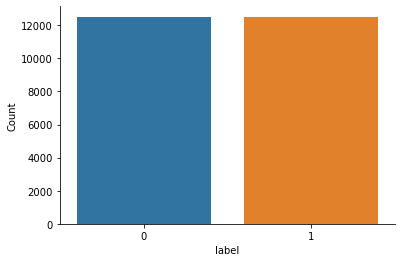

In [30]:
l = Counter(label_test)
m =  Counter(label_train)
s =  m 
labels = pd.DataFrame({'label':list(s.keys()),'Count':list(s.values())})
sns.barplot(data=labels,x='label',y='Count')
sns.despine()

On observe que dans notre jeu de données d'entraînement il y a un peu plus de commentaire positifs que de commentaires négatifs. Mais le jeu reste tout de même assez équilibré.

## Bag-of-word

Nous utilisons dans un premier temps, la représentation appelée "Bag-of-word.
Elle consiste à créer une grande matrice avec une colonne pour chaque mot unique dans le corpus.
Chaque commentaire correspond à une ligne contenant des 0 et des 1, où 1 signifie que le mot dans le corpus correspondant à cette colonne apparaît dans ce commentaire.
Chaque ligne de la matrice sera alors creuse, car il y aura beaucoup de zéros.
Ce processus est également appelé "one hot encoding".

In [31]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(binary=True)
cv.fit(reviews_train)
X = cv.transform(reviews_train)
X_test = cv.transform(reviews_test)

## TF-IDF

On peut également utiliser la représentation TF-IDF, elle permet d'évaluer l'importance d'un terme contenu dans un document.

### Term Frequency (TF)

TF représente le nombre de fois qu'un mot apparaît dans un commentaire divisé par le nombre total de mots dans le commentaire.
Chaque commentaire a son propre TF.

$$\mathrm{tf_{i,j}} = \frac{n_{i,j}}{\sum_k n_{i,j}}$$

### Inverse Data Frequency (IDF)

IDF représente le log du nombre de documents divisé par le nombre de documents qui contiennent le mot $t_i$.
IDF determine le poids des mots rares pour tous les commentaires du corpus.

$$\mathrm{idf_i} =  \log \frac{|D|}{|\{d_{j}: t_{i} \in d_{j}\}|}$$

où 
 - $|D|~$ : nombre total de commentaires dans le corpus 
 - $|\{d_{j} : t_{i} \in d_{j}\}|$ : nombre de commentaires où le terme $t_i$ apparaît (c'est-à-dire $n_{i,j} \neq 0$)

Et enfin, TF-IDF est simplement le TF multiplié par le IDF.

$$\mathrm{tfidf_{i,j}} = \mathrm{tf_{i,j}} \cdot  \mathrm{idf_{i}}$$

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit(reviews_train)
X_tfidf = tfidf_vectorizer.transform(reviews_train)
X_test_tfidf = tfidf_vectorizer.transform(reviews_test)

# Étape 4 : Application d'algorithmes de ML

Nous allons maintenant appliquer différents algorithmes de Machine Learning, pour pouvoir déterminer quels algorithmes prédisent le mieux le caractère positif ou négatif des commentaires. 

Nous utilisons ici comme métriques l'accuracy, le recall et le F1-score pour pouvoir comparer nos modèles entre eux à la fin. Néanmoins, étant donné que nos classes sont équilibrée dans le train on peut utiliser seulement l'accuracy.

 - Accuracy : 
$$accuracy = \frac{TP+TN}{TP+TN+FP+FN}\,,$$

 - Recall :
$$recall = \frac{TP}{TP+FN}\,,$$

 - F1 score : 
$$f1score = 2*\frac{precision*recall}{precision+recall}\,,$$
 
avec $TP$ : vrais positifs, $TN$ : vrais négatifs, $FP$ : faux positifs, $FN$ : faux négatifs et $precision = \frac{TP}{TP+FP}$

## Régression logistique

La régression logistique est un algorithme de Machine Learning qui est utilisé pour prédire la probabilité d'une variable binaire (ici il s'agit de 0 : commentaire positif et 1 : commentaire négatif).

On fait une régression logistique qui utilise une régression Ridge (penalty='l2') de paramètre C.

### Avec Bag-of-word

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

X_train, X_val, y_train, y_val = train_test_split(X, label_train, train_size = 0.75)

for c in [0.01, 0.05, 0.25, 0.5, 1]:    
    lr = LogisticRegression(C=c, max_iter = 100000)
    lr.fit(X_train, y_train)
    print ("Accuracy for C=%s: %s" % (c, accuracy_score(y_val, lr.predict(X_val))))

Accuracy for C=0.01: 0.86688
Accuracy for C=0.05: 0.87472
Accuracy for C=0.25: 0.872
Accuracy for C=0.5: 0.87024
Accuracy for C=1: 0.86496


Pour C = 0.05, on a l'accuracy la plus élevée.

On applique ce modèle.

In [34]:
final_model = LogisticRegression(C=0.05, max_iter = 100000)
final_model.fit(X, label_train)
print ("Final Accuracy: %s" 
       % accuracy_score(label_test, final_model.predict(X_test)))

Final Accuracy: 0.877


On trouve une accuracy d'environ 0.87.

On peut également regarder les 5 mots les plus discriminant pour les commentaires négatifs et positifs.
On regarde alors respectivement les plus grands et les plus petits coefficients.

In [35]:
feature_to_coef = {
    word: coef for word, coef in zip(
        cv.get_feature_names(), final_model.coef_[0])
}
for best_negative in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1], 
    reverse=True)[:5]:
    print (best_negative)

('excellent', 0.9239177641422607)
('superb', 0.7576425229026377)
('perfect', 0.7281045216178879)
('refresh', 0.7126421388270574)
('great', 0.711737521806289)


In [36]:
for best_positive in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1])[:5]:
    print (best_positive)

('waste', -1.2713214180523094)
('awful', -1.062575814384211)
('bad', -1.0532430580280396)
('poor', -0.8613708058126277)
('disappointment', -0.8392547649379972)


### Avec TF-IDF

In [37]:
X_train, X_val, y_train, y_val = train_test_split(X_tfidf, label_train, train_size = 0.75)

for c in [2,3,3.5, 4, 4.5,5,5.5,6]:    
    lr = LogisticRegression(C=c,  max_iter = 100000)
    lr.fit(X_train, y_train)
    print ("Accuracy for C=%s: %s" % (c, accuracy_score(y_val, lr.predict(X_val))))
    

Accuracy for C=2: 0.88752
Accuracy for C=3: 0.88864
Accuracy for C=3.5: 0.88864
Accuracy for C=4: 0.88816
Accuracy for C=4.5: 0.88816
Accuracy for C=5: 0.88832
Accuracy for C=5.5: 0.88896
Accuracy for C=6: 0.88976


In [38]:
final_model = LogisticRegression(C=3,  max_iter = 100000)
final_model.fit(X, label_train)
print ("Final Accuracy: %s" 
       % accuracy_score(label_test, final_model.predict(X_test_tfidf)))

Final Accuracy: 0.83652


On trouve une accuracy de 0.88.

In [39]:
feature_to_coef = {
    word: coef for word, coef in zip(
        cv.get_feature_names(), final_model.coef_[0])
}
for best_negative in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1], 
    reverse=True)[:5]:
    print (best_negative)

('refresh', 2.917277031799256)
('stereoscopic', 2.3682673564116636)
('superb', 2.2703905766356414)
('download', 2.2656695086867993)
('underrated', 2.228695722718096)


In [40]:
for best_positive in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1])[:5]:
    print (best_positive)

('unwatchable', -2.7119523675031623)
('waste', -2.6688323550395716)
('disappointment', -2.502462379247331)
('laughable', -2.3454010418172313)
('uninteresting', -2.332637924196423)


## SVM

On utilise également la régularisation Ridge(l2) de paramètre C.

### Avec bag-of-word

In [41]:
from sklearn.svm import LinearSVC

X_train, X_val, y_train, y_val = train_test_split(
    X, label_train, train_size = 0.75
)

for c in [0.01, 0.05, 0.25, 0.5, 1]:
    
    svm = LinearSVC(C=c,  max_iter = 100000)
    svm.fit(X_train, y_train)
    print ("Accuracy for C=%s: %s" 
           % (c, accuracy_score(y_val, svm.predict(X_val))))

Accuracy for C=0.01: 0.87808
Accuracy for C=0.05: 0.87072
Accuracy for C=0.25: 0.8576
Accuracy for C=0.5: 0.8536
Accuracy for C=1: 0.85008


In [42]:
final_svm_ngram = LinearSVC(C=0.01,  max_iter = 100000)
final_svm_ngram.fit(X, label_train)
print ("Final Accuracy: %s" 
       % accuracy_score(label_test, final_svm_ngram.predict(X_test)))

Final Accuracy: 0.87736


### Avec TF-IDF

In [43]:
from sklearn.svm import LinearSVC

X_train, X_val, y_train, y_val = train_test_split(
    X_tfidf, label_train, train_size = 0.75
)

for c in [0.01, 0.05, 0.25, 0.5, 1]:
    
    svm = LinearSVC(C=c)
    svm.fit(X_train, y_train)
    print ("Accuracy for C=%s: %s" 
           % (c, accuracy_score(y_val, svm.predict(X_val))))

Accuracy for C=0.01: 0.85888
Accuracy for C=0.05: 0.87904
Accuracy for C=0.25: 0.88944
Accuracy for C=0.5: 0.88976
Accuracy for C=1: 0.8848


In [44]:
final_svm = LinearSVC(C=0.5)
final_svm.fit(X_tfidf, label_train)
print ("Final Accuracy: %s" 
       % accuracy_score(label_test, final_svm.predict(X_test_tfidf)))

Final Accuracy: 0.88812


# Étape 5 : Comparaison des modèles

Pour comparer les différents modèles, on fait une validation croisée en 10 folds.

In [45]:
from sklearn import model_selection
seed = 7
# prepare models
models = []
models.append(('LR', LogisticRegression(C=0.05)))
models.append(('SVM', LinearSVC(C=0.01)))
# evaluate each model in turn
results_acc = []
results_rec = []
results_f1 = []
names = []
acc = 'accuracy'
rec = 'recall'
f1 = 'f1'
for name, model in models:
    kfold = model_selection.KFold(n_splits=10)
    cv_results_a = model_selection.cross_val_score(model, X, label_train, cv=kfold, scoring=acc)
    results_acc.append(cv_results_a)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results_a.mean(), cv_results_a.std())
    print("Accuracy : ", msg)
    cv_results_r = model_selection.cross_val_score(model, X, label_train, cv=kfold, scoring=rec)
    results_rec.append(cv_results_r)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results_r.mean(), cv_results_r.std())
    print("Recall : ",msg)
    cv_results_f1 = model_selection.cross_val_score(model, X, label_train, cv=kfold, scoring=f1)
    results_f1.append(cv_results_f1)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results_f1.mean(), cv_results_f1.std())
    print("F1 score : ",msg)

Accuracy :  LR: 0.880240 (0.005476)
Recall :  LR: 0.889753 (0.007914)
F1 score :  LR: 0.881427 (0.006328)
Accuracy :  SVM: 0.880160 (0.004965)
Recall :  SVM: 0.890460 (0.007907)
F1 score :  SVM: 0.881457 (0.005478)


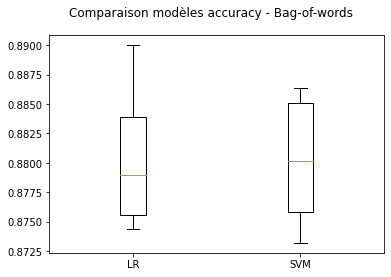

In [46]:
# boxplot algorithm comparison
names = ['LR', 'SVM']
fig = plt.figure()
fig.suptitle('Comparaison modèles accuracy - Bag-of-words')
ax = fig.add_subplot(111)
plt.boxplot(results_acc)
ax.set_xticklabels(names)
plt.show()

On trouve que SVM nous donne la meilleure accuray.

In [47]:
results_acc = []
results_rec = []
results_f1 = []
names = []
models = []
acc = 'accuracy'
rec = 'recall'
f1 = 'f1'
models.append(('LR', LogisticRegression(C=4,  max_iter = 100000)))
models.append(('SVM', LinearSVC(C=0.5,  max_iter = 100000)))
for name, model in models:
    kfold = model_selection.KFold(n_splits=10)
    cv_results_a = model_selection.cross_val_score(model, X_tfidf, label_train, cv=kfold, scoring=acc)
    results_acc.append(cv_results_a)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results_a.mean(), cv_results_a.std())
    print("Accuracy : ", msg)
    cv_results_r = model_selection.cross_val_score(model, X_tfidf, label_train, cv=kfold, scoring=rec)
    results_rec.append(cv_results_r)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results_r.mean(), cv_results_r.std())
    print("Recall : ",msg)
    cv_results_f1 = model_selection.cross_val_score(model, X_tfidf, label_train, cv=kfold, scoring=f1)
    results_f1.append(cv_results_f1)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results_f1.mean(), cv_results_f1.std())
    print("F1 score : ",msg)


Accuracy :  LR: 0.890120 (0.006003)
Recall :  LR: 0.901660 (0.009261)
F1 score :  LR: 0.891425 (0.006699)
Accuracy :  SVM: 0.889960 (0.005483)
Recall :  SVM: 0.900796 (0.010228)
F1 score :  SVM: 0.891208 (0.005895)


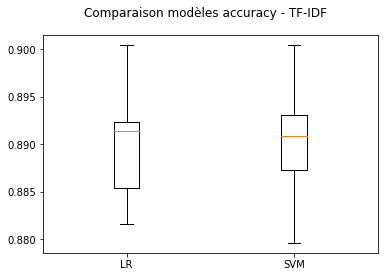

In [49]:
fig = plt.figure()
names = ['LR', 'SVM']
fig.suptitle('Comparaison modèles accuracy - TF-IDF')
ax = fig.add_subplot(111)
plt.boxplot(results_acc)
ax.set_xticklabels(names)
plt.show()

On remarque que les accuracy obtenues sont plutôt élevées et dans le cas de la représentation Bag-of-words, le meilleur algorithme est celui de la régression logistique alors que dans le cas du TF-IDF, le meilleur algorithme est le SVM.

## Référence : 

 - https://machinelearningmastery.com/prepare-movie-review-data-sentiment-analysis/